# Lab: Convolutional NNs for CIFAR 10


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [4]:
import torch
from torchvision import datasets, transforms, utils

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
trainset = datasets.CIFAR10(root='~/torch_datasets', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='~/torch_datasets', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170498071/170498071 [00:07<00:00, 21547653.39it/s]


Extracting /Users/lancho/torch_datasets/cifar-10-python.tar.gz to /Users/lancho/torch_datasets
Files already downloaded and verified


In [5]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

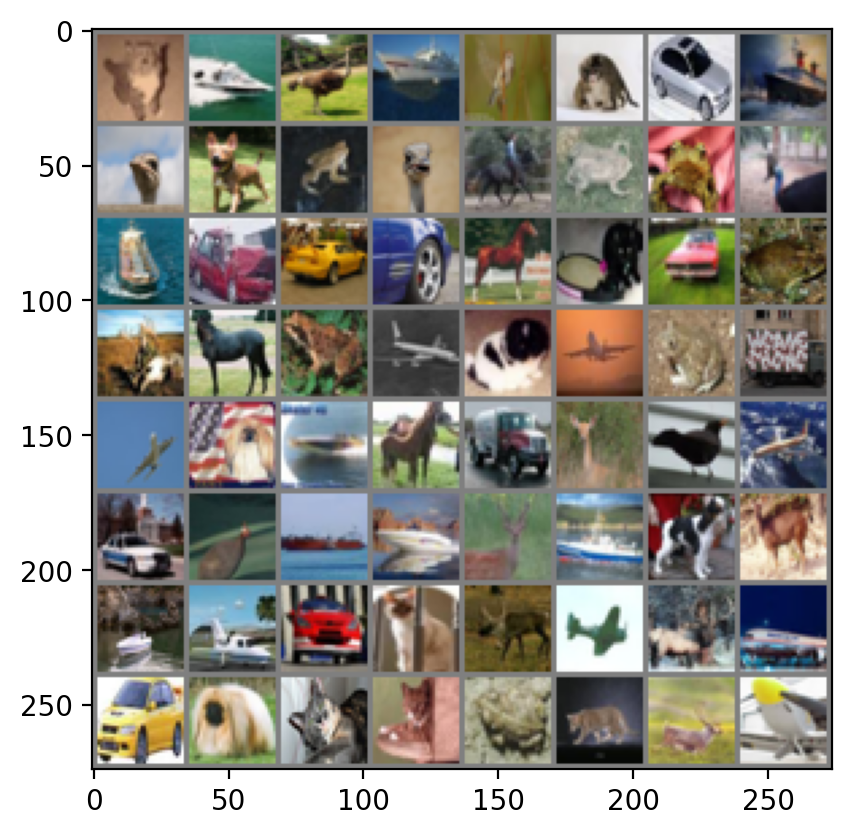

In [7]:
imshow(utils.make_grid(images))


> **Exercise:** Create a validation set using the 20% of train images

In [8]:
# YOUR CODE HERE
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [3]:
Image(url= "https://ichi.pro/assets/images/max/724/0*H9_eGAtkQXJXtkoK")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that FMNIST images are $28\times28$ (instead of $32\times32$), so some of the spatial dimensions in the image above are different.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [9]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,10)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)  #((32-4)/2-4)/2=5
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [10]:
class Lenet5_extended(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
    
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

In [11]:
my_CNN = Lenet5_extended(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.671874, Validation loss: 1.461757, Time per epoch: 44.346089 seconds
Epoch 1. Training loss: 1.389056, Validation loss: 1.310548, Time per epoch: 43.574625 seconds
Epoch 2. Training loss: 1.256524, Validation loss: 1.198553, Time per epoch: 43.528960 seconds
Epoch 3. Training loss: 1.158723, Validation loss: 1.127841, Time per epoch: 43.301007 seconds
Epoch 4. Training loss: 1.091011, Validation loss: 1.073586, Time per epoch: 43.755552 seconds


tensor(0.6440)
tensor(0.6208)


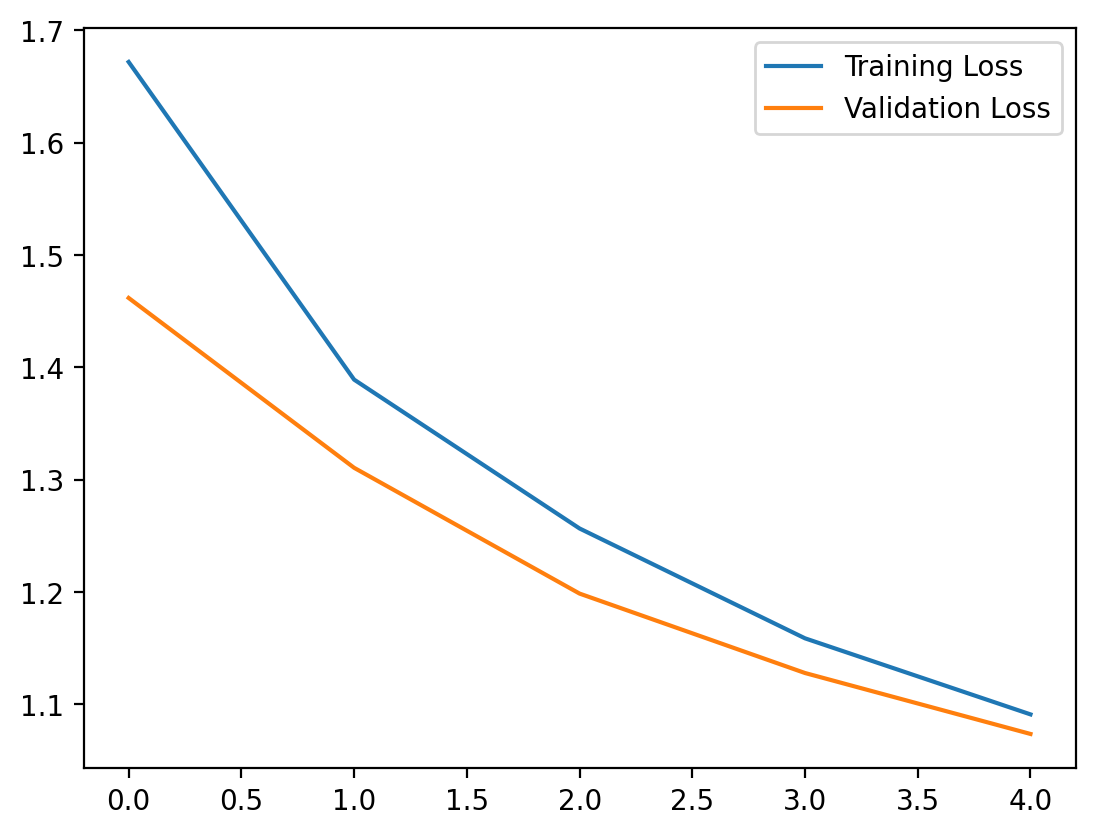

In [12]:
plt.plot(my_CNN.loss_during_training,label='Training Loss')
plt.plot(my_CNN.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN.eval_performance(trainloader))
print(my_CNN.eval_performance(validloader))

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [13]:
class Lenet5_extended_GPU(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                    
                    
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [14]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.675034, Validation loss: 1.491650, Time per epoch: 45.084402 seconds
Epoch 1. Training loss: 1.384259, Validation loss: 1.279018, Time per epoch: 43.816257 seconds
Epoch 2. Training loss: 1.262176, Validation loss: 1.228930, Time per epoch: 42.105387 seconds
Epoch 3. Training loss: 1.168938, Validation loss: 1.176779, Time per epoch: 42.503055 seconds
Epoch 4. Training loss: 1.096437, Validation loss: 1.132292, Time per epoch: 42.577153 seconds


tensor(0.6291)
tensor(0.6019)


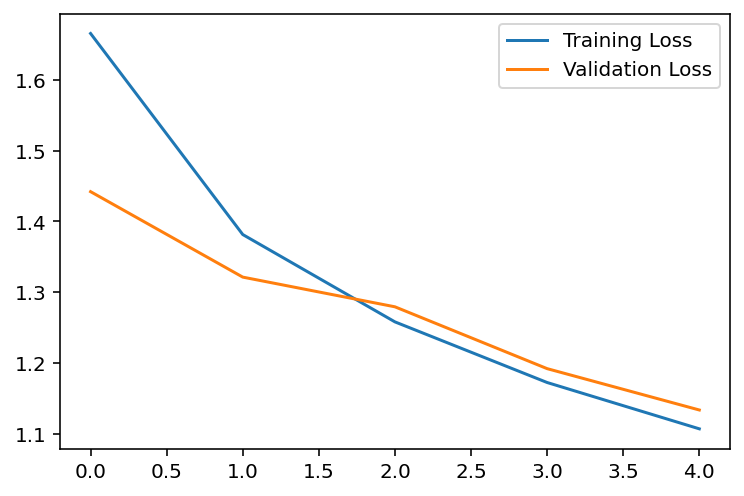

In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Compare the test performance achieved w.r.t. the MLP that was used in Lab 2

In [15]:
# We simply run more epochs of the above network

my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=20,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)


Epoch 0. Training loss: 1.663501, Validation loss: 1.515364, Time per epoch: 44.477053 seconds
Epoch 1. Training loss: 1.396925, Validation loss: 1.360052, Time per epoch: 44.905454 seconds
Epoch 2. Training loss: 1.277539, Validation loss: 1.219501, Time per epoch: 42.836380 seconds
Epoch 3. Training loss: 1.197359, Validation loss: 1.173130, Time per epoch: 43.364337 seconds
Epoch 4. Training loss: 1.124993, Validation loss: 1.164302, Time per epoch: 43.897344 seconds
Epoch 5. Training loss: 1.068745, Validation loss: 1.126138, Time per epoch: 43.668889 seconds
Epoch 6. Training loss: 1.021583, Validation loss: 1.104836, Time per epoch: 42.838126 seconds
Epoch 7. Training loss: 0.975482, Validation loss: 1.121514, Time per epoch: 42.486261 seconds
Epoch 8. Training loss: 0.937346, Validation loss: 1.063591, Time per epoch: 42.794949 seconds
Epoch 9. Training loss: 0.905691, Validation loss: 1.053722, Time per epoch: 43.358602 seconds
Epoch 10. Training loss: 0.870506, Validation loss

tensor(0.7951)
tensor(0.6373)


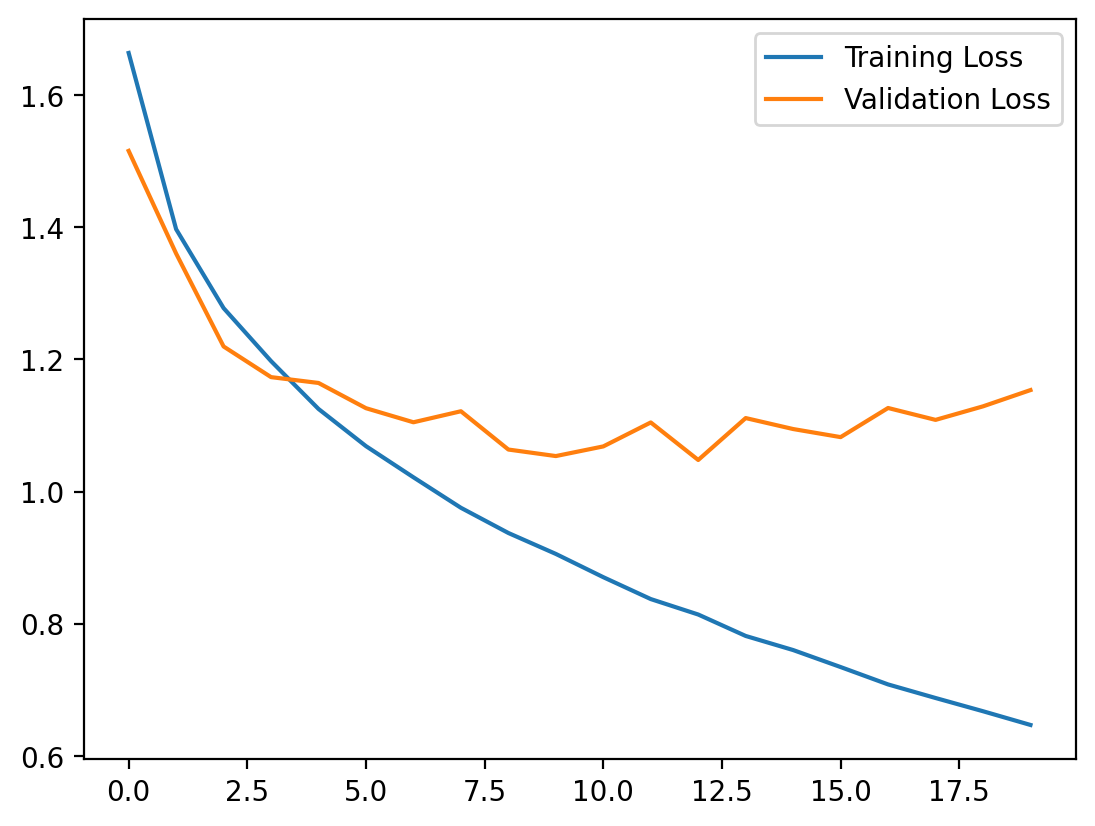

In [16]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

In [17]:
class Lenet5_Drop(nn.Module):
    def __init__(self,dimx,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120)
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,10)
    
        self.tanh = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.tanh(x) 
        x = self.pool(x)
        #x = self.dropout(x) 
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)
        x = self.dropout(x) 
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x

In [18]:
class Lenet5_extended_GPU_Drop(Lenet5_Drop):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,prob)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                    
                    
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    

            # set model back to train mode
            self.train()

            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0
        
        self.eval()
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            self.train()
            return accuracy/len(dataloader)

In [19]:
my_CNN_GPU_Drop = Lenet5_extended_GPU_Drop(dimx=32,nlabels=10,prob=0.5,epochs=20,lr=1e-3)
my_CNN_GPU_Drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.899694, Validation loss: 1.592947, Time per epoch: 43.276287 seconds
Epoch 1. Training loss: 1.637033, Validation loss: 1.439011, Time per epoch: 42.955341 seconds
Epoch 2. Training loss: 1.561007, Validation loss: 1.402175, Time per epoch: 42.792937 seconds
Epoch 3. Training loss: 1.512252, Validation loss: 1.342329, Time per epoch: 43.850045 seconds
Epoch 4. Training loss: 1.475335, Validation loss: 1.300688, Time per epoch: 45.545696 seconds
Epoch 5. Training loss: 1.445994, Validation loss: 1.307322, Time per epoch: 43.197836 seconds
Epoch 6. Training loss: 1.434598, Validation loss: 1.250605, Time per epoch: 43.291691 seconds
Epoch 7. Training loss: 1.411005, Validation loss: 1.240742, Time per epoch: 45.472250 seconds
Epoch 8. Training loss: 1.390936, Validation loss: 1.216819, Time per epoch: 44.958388 seconds
Epoch 9. Training loss: 1.379803, Validation loss: 1.181035, Time per epoch: 45.454605 seconds
Epoch 10. Training loss: 1.366574, Validation loss

In [20]:
my_CNN_GPU_Drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.282744, Validation loss: 1.116972, Time per epoch: 47.742832 seconds
Epoch 1. Training loss: 1.283576, Validation loss: 1.097432, Time per epoch: 48.565991 seconds
Epoch 2. Training loss: 1.286311, Validation loss: 1.062530, Time per epoch: 47.980218 seconds
Epoch 3. Training loss: 1.277364, Validation loss: 1.059878, Time per epoch: 47.673727 seconds
Epoch 4. Training loss: 1.273937, Validation loss: 1.063543, Time per epoch: 47.851769 seconds
Epoch 5. Training loss: 1.269177, Validation loss: 1.056526, Time per epoch: 46.815790 seconds
Epoch 6. Training loss: 1.272022, Validation loss: 1.051794, Time per epoch: 47.493683 seconds
Epoch 7. Training loss: 1.262550, Validation loss: 1.054557, Time per epoch: 47.396493 seconds
Epoch 8. Training loss: 1.261524, Validation loss: 1.074407, Time per epoch: 47.105039 seconds
Epoch 9. Training loss: 1.257350, Validation loss: 1.053956, Time per epoch: 47.864050 seconds
Epoch 10. Training loss: 1.253544, Validation loss

tensor(0.6620)
tensor(0.6408)


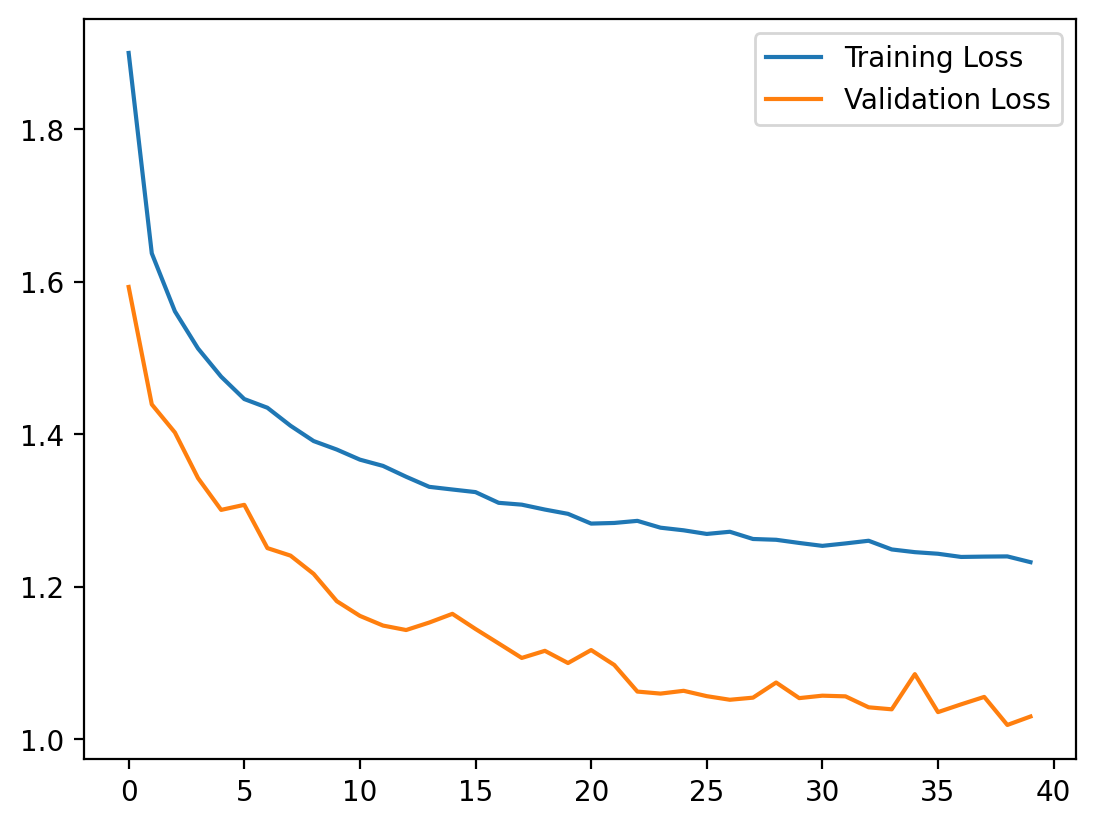

In [21]:
plt.plot(my_CNN_GPU_Drop.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU_Drop.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU_Drop.eval_performance(trainloader))
print(my_CNN_GPU_Drop.eval_performance(validloader))

### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the three of them ...

In [22]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)   
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)        
        x = self.output4(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

In [23]:
class MLPdrop_extended(MLPdrop):
    
    #Your code here
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,prob)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # set model back to train mode
        self.train()
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                #Your code here
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = self.forward(images.view(images.shape[0], -1))

                    #Your code here
                    loss = self.criterion(out,labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            # set model to evaluation mode
            self.eval()

            for images,labels in dataloader:

                probs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [24]:
my_MLP_drop = MLPdrop_extended(dimx=3072,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3,prob=0.2)

my_MLP_drop.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.786123, Validation loss: 1.638482
Epoch 1. Training loss: 1.618169, Validation loss: 1.512564
Epoch 2. Training loss: 1.541736, Validation loss: 1.467666
Epoch 3. Training loss: 1.483489, Validation loss: 1.416252
Epoch 4. Training loss: 1.438744, Validation loss: 1.402652
Epoch 5. Training loss: 1.399367, Validation loss: 1.391179
Epoch 6. Training loss: 1.371059, Validation loss: 1.359747
Epoch 7. Training loss: 1.339362, Validation loss: 1.357569
Epoch 8. Training loss: 1.308707, Validation loss: 1.333135
Epoch 9. Training loss: 1.288505, Validation loss: 1.345651
Epoch 10. Training loss: 1.265420, Validation loss: 1.344032
Epoch 11. Training loss: 1.237461, Validation loss: 1.325691
Epoch 12. Training loss: 1.221272, Validation loss: 1.316638
Epoch 13. Training loss: 1.204336, Validation loss: 1.324596
Epoch 14. Training loss: 1.184089, Validation loss: 1.333811
Epoch 15. Training loss: 1.172351, Validation loss: 1.304723
Epoch 16. Training loss: 1.155503,

tensor(0.7297)
tensor(0.5463)


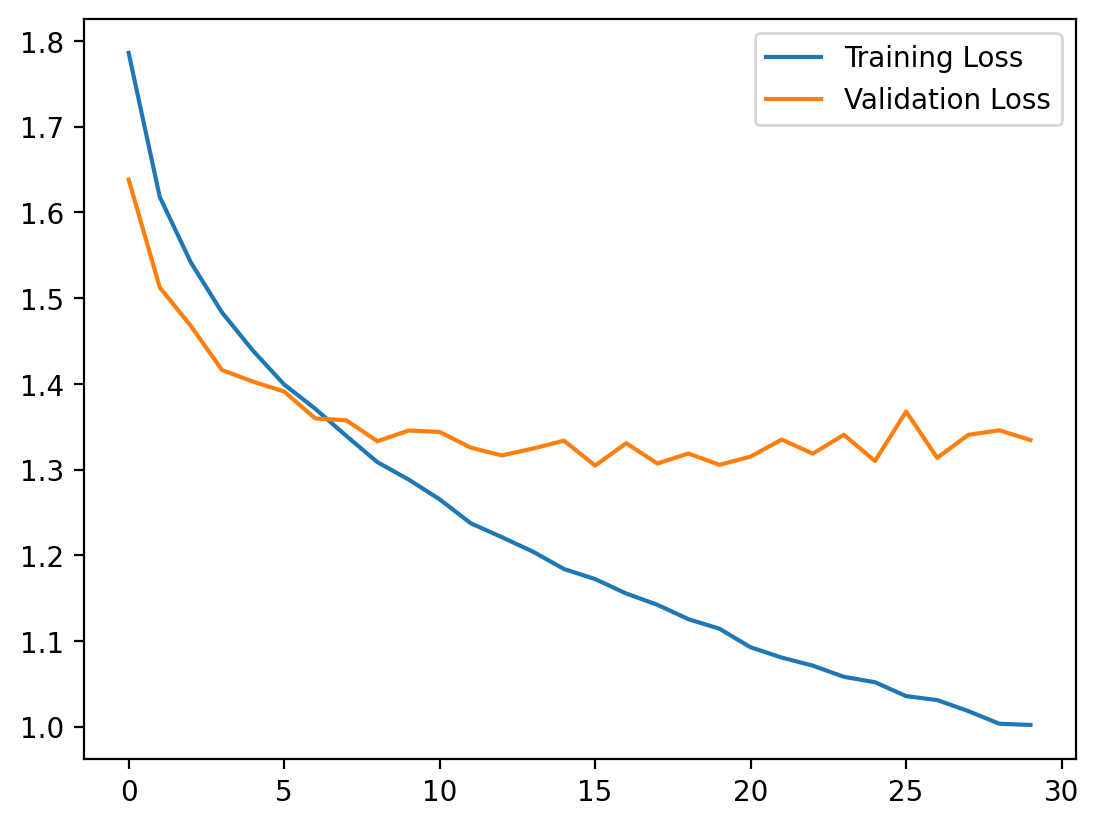

In [25]:
plt.plot(my_MLP_drop.loss_during_training,label='Training Loss')
plt.plot(my_MLP_drop.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_MLP_drop.eval_performance(trainloader))
print(my_MLP_drop.eval_performance(validloader))